# Chinook Digital Music Shop

The [Chinook database](https://github.com/lerocha/chinook-database) contains information about fictional digital music shop - kind of like a mini-iTunes store.

The Chinook database contains information about the artists, songs, albums, invoices, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables. Below is a schema diagram for the Chinook database to understand the available columns and the structure of the data:

<img src="https://s3.amazonaws.com/dq-content/189/chinook-schema.svg" width=600 height=400/>

Source: [DataQuest](https://www.dataquest.io/)

In this project, we're going to answer business questions using SQL. Qustions like what type of genre and track are sold in USA, collate data on purchases from different countries, categorize each invoice as either an album purchase or not, and so on..

Before we proceed with our analysis, we need to connect our Jupyter Notebook to our database file:

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

The database is connected. Next, we'll import required libraries for our project:

In [2]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline

## Overview of the Data

Let's start by getting familiar with our data. We can query the database to get a list of all tables and views in our database. To run SQL queries in Jupyter Notebook, we have to add `%%sql` on its own line to the start of our query.

So to execute the query that returns information on the tables and views in the database, we'll use the following code:

In [3]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


Now we'll write one or two queries to get familiar with the tables and to pratice running SQL in this interface. For reference, we can use the schema diagram from above.

In the first query, we'll get the track names and the album they belong to:

In [4]:
%%sql
SELECT
    t.name track,
    ai.title album
FROM track t
INNER JOIN album ai ON ai.album_id = t.album_id
LIMIT 5;

 * sqlite:///chinook.db
Done.


track,album
For Those About To Rock (We Salute You),For Those About To Rock We Salute You
Balls to the Wall,Balls to the Wall
Fast As a Shark,Restless and Wild
Restless and Wild,Restless and Wild
Princess of the Dawn,Restless and Wild


Second query will give us the information about track names, the genre they represent, and their media type:

In [5]:
%%sql
SELECT
    t.name track,
    g.name genre,
    mt.name media_type
FROM track t
INNER JOIN genre g ON g.genre_id = t.genre_id
INNER JOIN media_type mt ON mt.media_type_id = t.media_type_id
LIMIT 10;

 * sqlite:///chinook.db
Done.


track,genre,media_type
For Those About To Rock (We Salute You),Rock,MPEG audio file
Balls to the Wall,Rock,Protected AAC audio file
Fast As a Shark,Rock,Protected AAC audio file
Restless and Wild,Rock,Protected AAC audio file
Princess of the Dawn,Rock,Protected AAC audio file
Put The Finger On You,Rock,MPEG audio file
Let's Get It Up,Rock,MPEG audio file
Inject The Venom,Rock,MPEG audio file
Snowballed,Rock,MPEG audio file
Evil Walks,Rock,MPEG audio file


## Select Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| Artist Name          | Genre   |
|----------------------|---------|
| Regal                | Hip-Hop |
| Red Tone             | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blues   |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

we'll need to write a query to find out which genres sell the most tracks in the USA, write up a summary of our findings, and make a recommendation for the three artists whose albums we should purchase for the store.

Things to do:

1. Write a query that returns each genre, with the number of tracks sold in the USA:
    - in absolute numbers
    - in percentage
2. Write a paragraph that interprets the data and makes a recommendaion for the three artists whose albums we should purchase for the store, based on sales of tracks from their genres.

In [6]:
query = """
-- Extract tracks sold in USA
WITH usa_tracks_sold AS (SELECT il.*
                         FROM invoice_line il
                         INNER JOIN invoice i ON i.invoice_id = il.invoice_id
                         INNER JOIN customer c ON c.customer_id = i.customer_id
                         WHERE c.country = 'USA')

-- Extract the genre types, number of tracks sold, and their percentage in USA
SELECT
    g.name AS genre,
    COUNT(uts.invoice_line_id) AS tracks_sold,
    ROUND(CAST(COUNT(uts.invoice_line_id) AS FLOAT) * 100 /
              (SELECT COUNT(*) FROM usa_tracks_sold), 0) AS percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t ON t.track_id = uts.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY genre
ORDER BY tracks_sold DESC
LIMIT 10;
"""

# SQL output to pandas dataframe
conn = sqlite3.connect('chinook.db')
df = pd.read_sql_query(query, conn)
df = df.set_index('genre') # remove default index and set as 'genre'
df

,tracks_sold,percentage_sold
genre,,
Rock,561,53.0
Alternative & Punk,130,12.0
Metal,124,12.0
R&B/Soul,53,5.0
Blues,36,3.0
Alternative,35,3.0
Pop,22,2.0
Latin,22,2.0
Hip Hop/Rap,20,2.0


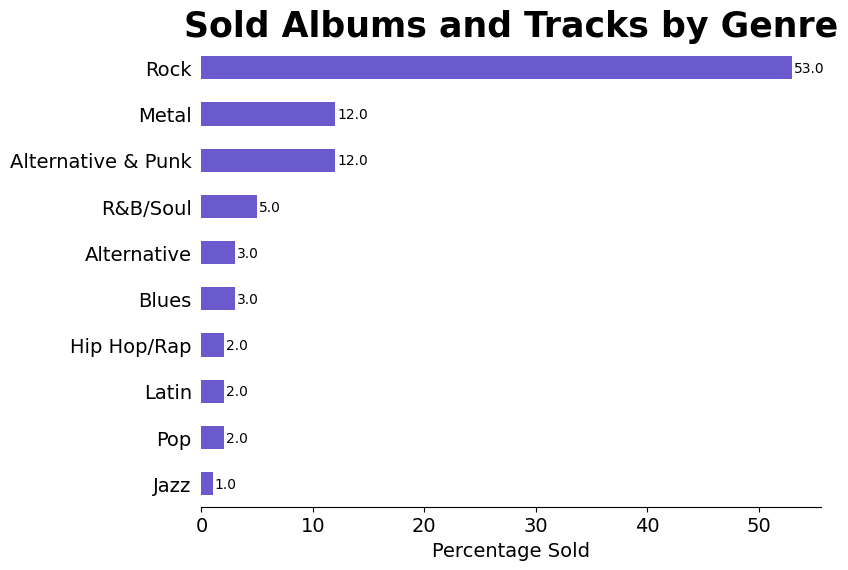

In [7]:
# Plot sold tracks in USA by genre in %
fig, ax = plt.subplots(figsize=(8, 6))

df['percentage_sold'].sort_values().plot.barh(color='slateblue', rot=0)
ax.set_title('Sold Albums and Tracks by Genre', fontsize=25, fontweight='bold')
ax.tick_params(axis='both', labelsize=14, left=False)
ax.set_xlabel('Percentage Sold', fontsize=14)
ax.set_ylabel(None)
# Display bar values
for i, v in enumerate(df['percentage_sold'][::-1]): # inverse the list to display appropiate values
    ax.text(v + 0.2, i - 0.1, str(v))


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following three artists:

- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the `Rock` genre, which accounts for 53% of sales.

## Analyze Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

We might like to consider whether any extra columns from the employee table explain any variance we see, or whether the variance might instead be indicative of employee performance.

Things to do:

1. Write a query that finds the total dollar amount of sales assigned to each sales support agent within the company. Add any extra attributes for that employee that we find are relevant to the analysis.
2. Write a short statement describing our results, and providing a possible interpretation.

In [8]:
query = """
-- Customers total purchase, country, and the agent assigned to them
WITH customer_invoice_total AS (SELECT
                                    i.customer_id,
                                    SUM(i.total) AS total_purchase,
                                    c.support_rep_id,
                                    c.country AS customer_country
                                FROM customer c
                                INNER JOIN invoice i ON i.customer_id = c.customer_id
                                GROUP BY 1),

-- Employee each sale on customer from Canada and overseas
    employee_cit AS (SELECT
                        e.first_name || ' ' || e.last_name AS employee_name,
                        cit.total_purchase AS total_purchase,
                        e.country AS employee_country,
                        cit.customer_country,
                        (CASE
                         WHEN cit.customer_country = 'Canada'
                         THEN 'Same country'
                         END) AS employee_vs_cust_country_same,
                        (CASE
                         WHEN cit.customer_country <> 'Canada'
                         THEN 'Different country'
                         END) AS employee_vs_cust_country_diff
                    FROM employee e
                    INNER JOIN customer_invoice_total cit ON cit.support_rep_id = e.employee_id),
    
--- Employee total sales on customers from Canada and overseas
    employee_total_cit AS (SELECT
                                ecit.employee_name,
                                SUM(CASE WHEN ecit.employee_vs_cust_country_same = 'Same country'
                                    THEN 1
                                    ELSE 0
                                    END) AS customer_canada,
                                SUM(CASE WHEN ecit.employee_vs_cust_country_diff = 'Different country'
                                    THEN 1
                                    ELSE 0
                                    END) AS customer_diff_country
                            FROM employee_cit ecit
                            GROUP BY 1),
    
-- Employee total sales
    employee_income AS (SELECT
                            ecit.employee_name,
                            SUM(ecit.total_purchase) AS total_purchase
                        FROM employee_cit AS ecit
                        GROUP BY 1
                        ORDER BY 2 DESC)
                        
-- Access columns of employee name, total purchase ($), total sales in Canada, and total sales in overseas
SELECT
    ei.employee_name,
    '$' || ROUND(ei.total_purchase, 2) AS total_purchase,
    etcit.customer_canada,
    etcit.customer_diff_country
FROM employee_income AS ei
INNER JOIN employee_total_cit etcit ON etcit.employee_name = ei.employee_name
"""

conn = sqlite3.connect('chinook.db')
df1 = pd.read_sql_query(query, conn)
df1

,employee_name,total_purchase,customer_canada,customer_diff_country
0,Jane Peacock,$1731.51,5,16
1,Margaret Park,$1584.0,1,19
2,Steve Johnson,$1393.92,2,16


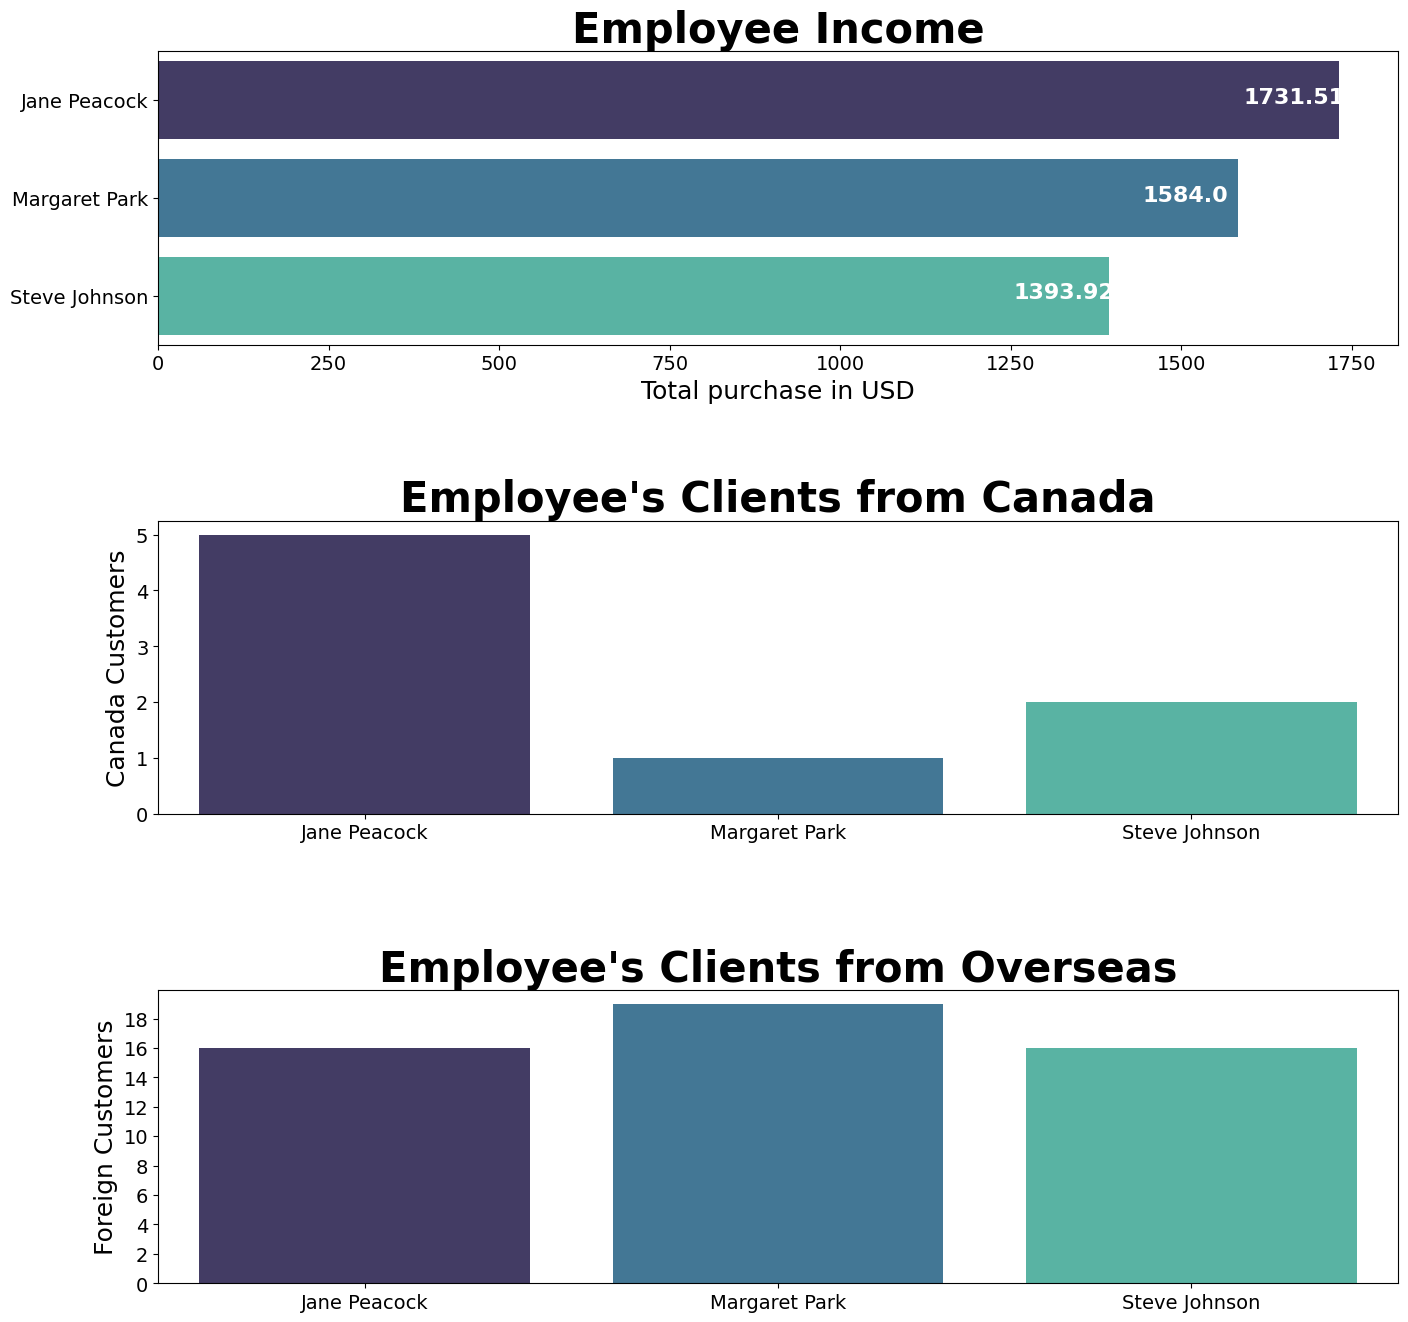

In [9]:
# Remove '$' sign from 'total_purchase' and convert data type to 'float'
total_purchase = df1['total_purchase'].str.replace('$', '', regex=False).str.strip()

# Create a column 'total_purchase_float' in df1 and
# Convert 'total_purchase' data type to float
df1['total_purchase_float'] = total_purchase.astype(float)

# Define figure and axes
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(16, 16))

# Plot employee income
sns.barplot(ax=ax1, x='total_purchase_float', y='employee_name', data=df1, palette='mako')
ax1.set_title('Employee Income', fontsize=30, fontweight='bold')
ax1.set_xlabel('Total purchase in USD', fontsize=18)
ax1.set_ylabel(None)
plt.setp(ax1.get_xticklabels(), fontsize=14)
plt.setp(ax1.get_yticklabels(), fontsize=14)
# Add bar values
for i, v in enumerate(df1['total_purchase_float']):
    ax1.text(v - 140, i + 0.03, str(v), fontsize=16, fontweight='bold', color='white')

# Plot employee's clients from Canada
sns.barplot(ax=ax2, x='employee_name', y='customer_canada', data=df1, palette='mako')
ax2.set_title("Employee's Clients from Canada", fontsize=30, fontweight='bold')
ax2.set_xlabel(None)
ax2.set_ylabel('Canada Customers', fontsize=18)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)

# Plot employee's clients from overseas
sns.barplot(ax=ax3, x='employee_name', y='customer_diff_country', data=df1, palette='mako')
ax3.set_title("Employee's Clients from Overseas", fontsize=30, fontweight='bold')
ax3.set_xlabel(None)
ax3.set_ylabel('Foreign Customers', fontsize=18)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
# Convert yaxis ticks from float to integer
ax3.yaxis.set_major_locator(MaxNLocator(integer=True))


# Add spaces between plots
fig.subplots_adjust(hspace=0.6)
plt.show()

As we can see `Jane Peacock` is the best sales agent with total amount of `$1731.50`, `Margaret Park` comes second with `$1584` and then comes `Steve Johnson` around `$1394` in total sales. Because we have more data to analyze these figures, let's draw a *bigger picture* to extract the insights from these numbers.

We see that Jane Peacock is the best agent, but more in the *local market*. To be specific: in Canada. On the other hand, Margaret Park has more success with the clients from overseas. This comparison makes these two employees a team of the best sales agent in the local and international market.

This knowledge can be useful to the company for developing future campaigns.

The last thing worth mentioning here that the total number of clients for each sales agent is slightly different. Jane Peacock has the most client `21`, Margaret Park has `20` and Steve Johnson has the smallest amount of clients, `18`. That can explain the lowest income made by him.

If we calculate the average income from one client in the case of `Jane Peacock`, we'll get:

```
1731.51 / 21 = $82.45
```

If `Steve Johnson` had 21 clients then he would earn more. Steve has 18 clients, so if we were to add 3 more clients (to compare him with Jane) with the assumption that each of those clients will add `$82.45` into Steve income, then the total would be:

```
1393.92 + (3 * 82.45) = $1641.27
```

Similarly, If we calculate the average income of each client `Margaret` has made, that would be:

```
1584 / 20 = $79.2
```

And making same assumption like before, with 20 clients Steve income would be:

```
1393.92 + (2 * 79.2) = $1552.32
```

The conclusion is, probably `Steve Johnson` is a good sales agent too, but he just has fewer customers. If possible, we recommend checking how his performance would be with a bigger client's database. If employees are responsible for finding clients, or persuade someone to be one, then it indicates that indeed `Steve Johnson` has lower performance and brings lower income for the company.

## Analyze Sales by Country

Our next task is to analyze the sales data for customers from each different country. We have been given guidance to use the country value from the `customers` table, and ignore the country from the billing address in the `invoice` table.

In particular, we have been directed to calculate data, for each country, on the:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

Because there are a number of countries with only one customer, we should group these customers as "Other" in our analysis. We can use the following 'tick' to force the ordering of "Other" to last in our analysis.

If there is a particular value that we would like to force to the top or bottom of results, we can put what normally be our most outer query in a subquery with a case statement that adds a numeric column, and then in the outer query sort by that column. Here's an example - let's start by creating a view so we're working with a manageable number of rows:

```sql
CREATE VIEW top_5_names AS
     SELECT
         first_name,
         count(customer_id) count
     FROM customer
     GROUP by 1
     ORDER by 2 DESC
     LIMIT 5;


SELECT * FROM top_5_names;
```

|   | first_name | count |
|---|------------|-------|
| 0 | Frank      | 2     |
| 1 | Mark       | 2     |
| 2 | Aaron      | 1     |
| 3 | Alexandre  | 1     |
| 4 | Astid      | 1     |


Next, inside a subquery, we'll select all values from our view and add a sorting column using a case statement, before sorting using that new column in the outer query.

```sql
SELECT
    first_name,
    count
FROM
    (
    SELECT
        t5.*,
        CASE
            WHEN t5.first_name = "Mark" THEN 1
            ELSE 0
        END AS sort
    FROM top_5_names t5
   )
ORDER BY sort ASC
```

|   | first_name | count |
|---|------------|-------|
| 0 | Frank      | 2     |
| 1 | Aaron      | 1     |
| 2 | Alexandre  | 1     |
| 3 | Astid      | 1     |
| 4 | Mark       | 2     |

We should be able to adapt this technique into our query to force 'Other' to the bottom of our results. When working through this task, we'll need multiple subqueries and joins. Imagine we work on a team of data analysts, and write our query so that it will be able to be easily read and understood by our colleagues.

Things to do:

- Write a query that collates data on purchases from different countries:
    - Where a country has only one customer, collect them into an "Other" group.
    - The results should be sorted by the total sales from highest to lowest, with the "Other" group at the very bottom.
    - For each country, include:
        - total number of customers
        - total value of sales
        - average value of sales per customer
        - average order value

In [10]:
query = """ 
-- Count number of sales and sum of total transaction, also group the results by customer country and id
WITH sales_per_customer AS   (SELECT
                                  c.country, 
                                  c.customer_id,
                                  ROUND(SUM(i.total), 0) AS total,
                                  COUNT(i.invoice_id) AS num_sales
                              FROM customer c
                              INNER JOIN invoice i ON i.customer_id=c.customer_id
                              GROUP BY 1, 2),
                              
-- Using 'sales_per_customer' and 'customer_id' table, caculate sales per customer and average order,
-- group the results by customer country
     all_countries AS        (SELECT
                                 c.country,
                                 COUNT(c.customer_id) AS customers,
                                 ROUND(SUM(spc.total), 0) AS total_sales,
                                 ROUND(AVG(spc.num_sales), 1) AS sales_per_customer,
                                 ROUND(AVG(spc.total), 0) AS avg_order
                              FROM customer c
                              INNER JOIN sales_per_customer spc ON spc.customer_id = c.customer_id
                              GROUP BY 1),
                              
-- Using 'all_countries' table, extract countries with only 1 customer    
     only_1_customer AS      (SELECT
                                 COUNT(country) AS country,
                                 COUNT(customers) AS customers,
                                 SUM(total_sales) AS total_sales,
                                 ROUND(AVG(sales_per_customer), 0) AS sales_per_customer, 
                                 ROUND(AVG(avg_order), 0) AS avg_order
                              FROM all_countries
                              WHERE customers = 1),  
                              
-- Assign the value 'Other' in country column of 'only_1_customer'           
    other_countries AS       (SELECT
                                  CASE
                                  WHEN country = (SELECT country FROM only_1_customer) THEN "Other"
                                  END AS country, 
                                  customers,
                                  total_sales, 
                                  sales_per_customer, 
                                  avg_order
                              FROM only_1_customer),
                              
-- Extract countries with more than 1 customer in 'all_countries' table,
-- sort the results by country
     more_than_1_customer AS (SELECT * 
                              FROM all_countries 
                              WHERE customers > 1
                              ORDER BY 1),
                              
-- Combine the results for 'other_countries' and 'more_than_1_customer' tables        
     united_unsorted AS      (SELECT * FROM other_countries
                              UNION 
                              SELECT * FROM more_than_1_customer)   

-- Calculate total number of customers, total sales, average sales per customer, and average order value for each country,
-- also sort the results by country and total sales in descending order
SELECT
    country,
    customers,
    total_sales,
    ROUND(customers * 100.0/(SELECT SUM(customers) 
                             FROM united_unsorted), 0) AS pct_customers,
    ROUND(total_sales * 100.0/(SELECT SUM(total_sales) 
                               FROM united_unsorted), 0) AS pct_sales,       
    sales_per_customer,
    avg_order
FROM (SELECT
          united_unsorted.*,
          CASE
          WHEN united_unsorted.country = "Other" THEN 1
          ELSE 0
          END AS sort_countries
      FROM united_unsorted)
ORDER BY sort_countries ASC, total_sales DESC;
"""

conn = sqlite3.connect("chinook.db")
df2 = pd.read_sql_query(query, conn)
df2

,country,customers,total_sales,pct_customers,pct_sales,sales_per_customer,avg_order
0,USA,13,1038.0,22.0,22.0,10.1,80.0
1,Canada,8,535.0,14.0,11.0,9.5,67.0
2,Brazil,5,427.0,8.0,9.0,12.2,85.0
3,France,5,388.0,8.0,8.0,10.0,78.0
4,Germany,4,334.0,7.0,7.0,10.3,84.0
5,Czech Republic,2,274.0,3.0,6.0,15.0,137.0
6,United Kingdom,3,245.0,5.0,5.0,9.3,82.0
7,Portugal,2,185.0,3.0,4.0,14.5,93.0
8,India,2,183.0,3.0,4.0,10.5,92.0
9,Other,15,1093.0,25.0,23.0,10.0,73.0


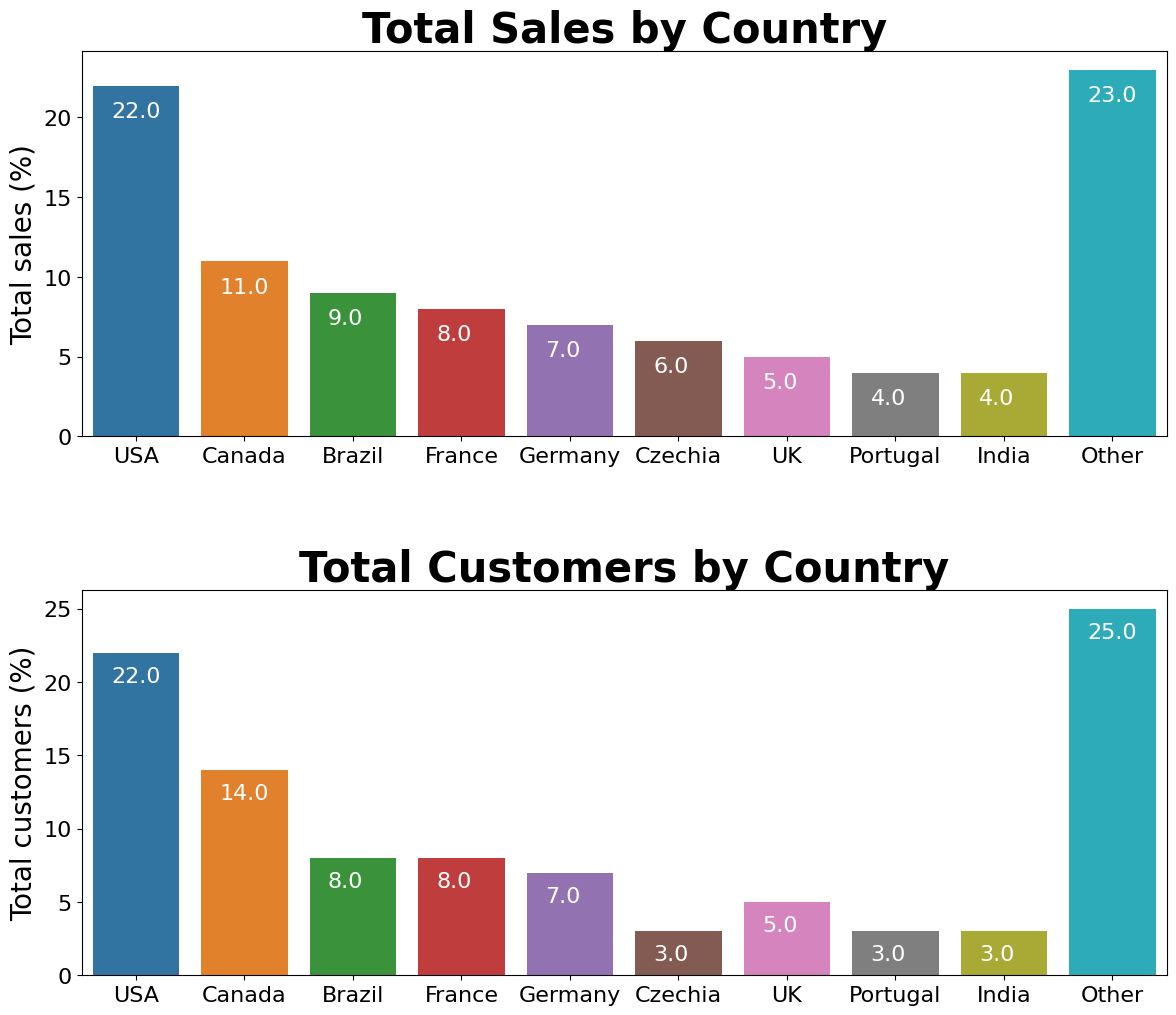

In [11]:
# Rename 'Czech Republic' to 'Czechia' and 'United Kingdom' to 'UK'
df2.loc[5, 'country'] = 'Czechia'
df2.loc[6, 'country'] = 'UK'

# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 12))

# Plot total sales percentage by each country
sns.barplot(ax=ax1, x='country', y='pct_sales', data=df2)
ax1.set_title('Total Sales by Country', fontsize=30, fontweight='bold')
ax1.set_xlabel(None)
ax1.set_ylabel('Total sales (%)', fontsize=20)
plt.setp(ax1.get_xticklabels(), fontsize=16)
plt.setp(ax1.get_yticklabels(), fontsize=16)
for i, v in enumerate(df2['pct_sales']):
    ax1.text(i-0.23, v-2, str(v), fontsize=16, color='white')

# Plot total customers percentage by each country
sns.barplot(ax=ax2, x='country', y='pct_customers', data=df2)
ax2.set_title('Total Customers by Country', fontsize=30, fontweight='bold')
ax2.set_xlabel(None)
ax2.set_ylabel('Total customers (%)', fontsize=20)
plt.setp(ax2.get_xticklabels(), fontsize=16)
plt.setp(ax2.get_yticklabels(), fontsize=16)
for i, v in enumerate(df2['pct_customers']):
    ax2.text(i-0.23, v-2, str(v), fontsize=16, color='white')

fig.subplots_adjust(hspace=0.4)
plt.show()

The sales by country are evidently dominated by the `USA`, in terms of both the total sales and the number of customers (if not to count the `Other` group). Besides, we can notice a strong positive correlation between the number of customers and the total sales. Interestingly `Czezchia`, having only 2 customers, shows the highest average value of sales per customer and consequently, the highest average order value.

## Albums vs Individual Tracks

In the Chinook store, customers can make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks

The store doesn't let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currectly considering changing their purchasing strategy so that to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album. Our task is to find out what percentage of purchases are individual tracks vs whole albums. This data will further be used to understand the effect this new strategy might have on overall revenue.

Here we have two edge cases to consider:

- Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
- Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case doesn't happen often, so we can ignore this case also.

In order to answer our question, we're going to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks, as long as we decided to ignore the second edge case.

In this way, we'll categorize each invoice as a purchase of either a whole album or individual tracks, and calculate the summary statistics for both groups (number and percentage of invoices). For this purpose, we'll use the following tables: `invoice_line`, `track`, and `album`.

In [12]:
query = """
-- Get invoice id and album id
WITH invoice_album_id AS (SELECT
                              il.invoice_id,
                              t.album_id
                          FROM invoice_line il
                          LEFT JOIN track t ON t.track_id = il.track_id
                          GROUP BY 1),
-- Extract album and track purchase by comparing 'invoice_line' and 'track' tables with 'album' table
    album_vs_tracks AS   (SELECT
                             iai.*,
                             CASE
                             WHEN (SELECT il.track_id
                                   FROM invoice_line il
                                   WHERE il.invoice_id = iai.invoice_id
                                   EXCEPT
                                   SELECT t.track_id
                                   FROM track t
                                   WHERE t.album_id = iai.album_id) IS NULL

                             AND (SELECT t.track_id
                                  FROM track t
                                  WHERE t.album_id = iai.album_id
                                  EXCEPT
                                  SELECT il.track_id
                                  FROM invoice_line il
                                  WHERE il.invoice_id = iai.invoice_id) IS NULL

                             THEN 'Albums'
                             ELSE 'Tracks'
                             END AS purchase
                         FROM invoice_album_id iai)

-- Calculate total number of invoices and percentage for Albums and Tracks purchases from 'album_vs_tracks' table
-- group the results by purchase and sort by number of invoices in descending order
SELECT
    purchase,
    COUNT(*) AS num_invoices,
    ROUND(COUNT(*) * 100.0/(SELECT COUNT(*)
                            FROM invoice), 0) pct
FROM album_vs_tracks
GROUP BY 1
ORDER BY 2 DESC
"""

conn = sqlite3.connect('chinook.db')
df3 = pd.read_sql_query(query, conn)
df3

,purchase,num_invoices,pct
0,Tracks,500,81.0
1,Albums,114,19.0


We see the trend that customers are more likely to buy tracks than albums. Next, We'll represent the results graphically.

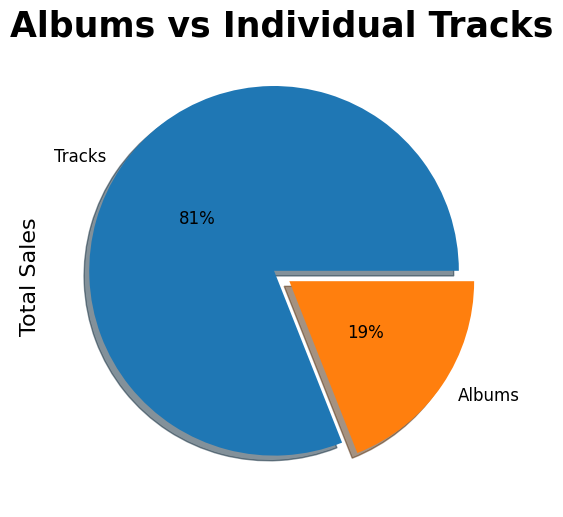

In [13]:
# Plot pie-chart
plt.figure(figsize=(6, 6))

plt.pie(x=df3['pct'], labels=df3['purchase'],
        autopct='%.0f%%', explode=[0.05]*2,
        pctdistance=0.5, shadow=True,
        textprops={'fontsize': 12})

plt.title('Albums vs Individual Tracks', fontsize=25, fontweight='bold')
plt.ylabel('Total Sales', fontsize=16)

plt.show()

Hence, customers tend to buy **individual tracks** 4 times more often than the whole albums. This means that the new strategy in consideration (purchasing only the most popular tracks from each album from record companies instead of purchasing the whole albums) will definitely help to maximize the overall revenue.

## The Most Popular Artists

Next, we're going to find out which artists are used in the most playlists. This information can give us valuable insights on further purchasing strategies of the Chinook store. The tables to be used are `artist`, `album`, `track`, and `playlist_track`.

In [14]:
%%sql

SELECT
    ar.name AS artist_name,
    COUNT(DISTINCT(pt.playlist_id)) AS num_playlists
FROM artist ar
INNER JOIN album al ON al.artist_id = ar.artist_id
INNER JOIN track t ON t.album_id = al.album_id
INNER JOIN playlist_track pt ON pt.track_id = t.track_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 5;

 * sqlite:///chinook.db
Done.


artist_name,num_playlists
Eugene Ormandy,7
The King's Singers,6
English Concert & Trevor Pinnock,6
Berliner Philharmoniker & Herbert Von Karajan,6
Academy of St. Martin in the Fields & Sir Neville Marriner,6


We got a table of the *Top 5* artists, with Eugene Ormandy at the first place (present in 7 playlists), and followed by 4 other artists (present in 6 playlists). Let's have a look to which genres the tracks of these artists are related.

In [15]:
%%sql

SELECT DISTINCT(g.name) AS genre
FROM genre g
INNER JOIN track t ON t.genre_id = g.genre_id
INNER JOIN album al ON al.album_id = t.album_id
INNER JOIN artist ar ON ar.artist_id = al.artist_id
WHERE ar.name = 'Eugene Ormandy'
    OR ar.name = "The King's Singers"
    OR ar.name = "English Concert & Trevor Pinnock"
    OR ar.name = "Berliner Philharmoniker & Herbert Von Karajan" 
    OR ar.name = "Academy of St. Martin in the Fields & Sir Neville Marriner";

 * sqlite:///chinook.db
Done.


genre
Classical


From one of our previous queries, in which we calculated the number and percentage of tracks of each genre sold in the USA, we had the `Classical` genre as well, but it is far away from being the most sold one. Hence, despite these artists being present in the most playlists, a strategy for the chinook store to buy more tracks of theirs *can't be considered as potentially profitable* and should be disregarded.

## Purchased vs Not Purchased Tracks

Let's now calculate how many unique tracks were sold.

In [16]:
%%sql

With all_vs_sold AS (SELECT
                        COUNT(DISTINCT(t.track_id)) AS all_tracks,
                        COUNT(DISTINCT(il.track_id)) AS sold_tracks
                     FROM track t
                     LEFT JOIN invoice_line il ON il.track_id = t.track_id)

SELECT
    avs.*,
    ROUND(sold_tracks * 100.0 / all_tracks, 0) AS pct_sold
FROM all_vs_sold avs;

 * sqlite:///chinook.db
Done.


all_tracks,sold_tracks,pct_sold
3503,1806,52.0


Almost half of all the unique tracks available in the Chinook store were never bought, probably being of unpopular genre or unpopular artists. Possible solutions here may include a new *advertising campaign* (especially in the USA, as the biggest segment of market), *sales promotion*, additional *training and motivation* of the sales support agents.

## Popularity of Protected vs Non-Protected Media Types

If a track has a protected media type, it means that it has some associated rules for using its content. It can be encrypted using some form of digital rights management encryption. To play such a file, playback must occur inside the protected media path. In addition, the user might have to acquire rights to the content.

Let's start by looking at the unique values of media types and whether there are any protected types among them.

In [17]:
%%sql
SELECT DISTINCT(name) AS media_type
FROM media_type;

 * sqlite:///chinook.db
Done.


media_type
MPEG audio file
Protected AAC audio file
Protected MPEG-4 video file
Purchased AAC audio file
AAC audio file


Two of the five media types are protected.

Now, we're going to calculate the summary statistics for all protected vs non-protected media types, and create some charts for them.

In [18]:
query = """ 
-- Extract non-protected media types
WITH non_protected AS (SELECT
                            COUNT(mt.name) AS to_be_renamed, 
                            COUNT(DISTINCT(t.track_id)) AS unique_tracks, 
                            COUNT(DISTINCT(il.track_id)) AS sold_unique,
                            COUNT(il.track_id) AS sold
                       FROM media_type mt
                       INNER JOIN track t ON mt.media_type_id = t.media_type_id
                       LEFT JOIN invoice_line il ON il.track_id = t.track_id                        
                       WHERE mt.name != "Protected AAC audio file"
                           AND mt.name != "Protected MPEG-4 video file"),

-- Extract protected media types
     protected AS     (SELECT
                             COUNT(mt.name) AS to_be_renamed, 
                             COUNT(DISTINCT(t.track_id)) AS unique_tracks, 
                             COUNT(DISTINCT(il.track_id)) AS sold_unique,
                             COUNT(il.track_id) AS sold
                       FROM media_type mt
                       INNER JOIN track t ON mt.media_type_id = t.media_type_id
                       LEFT JOIN invoice_line il ON il.track_id = t.track_id                        
                       WHERE mt.name = "Protected AAC audio file" 
                           OR mt.name = "Protected MPEG-4 video file"),

-- Combine 'non-protected' and 'protected' tables
     united AS        (SELECT
                             CASE WHEN to_be_renamed != 0 THEN "Non-protected"
                             END AS media_type,
                             unique_tracks,
                             sold_unique,
                             ROUND(sold_unique * 100.0 / unique_tracks, 0) AS pct_sold_unique,
                             sold  
                       FROM non_protected
                       UNION
                       SELECT
                           CASE WHEN to_be_renamed != 0 THEN "Protected"
                           END AS media_type,
                           unique_tracks,
                           sold_unique,
                           ROUND(sold_unique * 100.0 / unique_tracks, 0) pct_sold_unique,
                           sold
                       FROM protected)

-- Calculate the percentage of non-protected and protected tracks and their sales percentage
SELECT
    media_type,
    unique_tracks,
    ROUND(unique_tracks * 100.0 / (SELECT SUM(unique_tracks) 
                                   FROM united), 0) AS pct_unique,
    sold_unique,
    pct_sold_unique,
    sold,
    ROUND(sold * 100.0 / (SELECT SUM(sold) 
                          FROM united), 0) AS pct_sold
FROM united
"""

conn = sqlite3.connect('chinook.db')
df4 = pd.read_sql_query(query, conn)
df4

,media_type,unique_tracks,pct_unique,sold_unique,pct_sold_unique,sold,pct_sold
0,Non-protected,3052,87.0,1652,54.0,4315,91.0
1,Protected,451,13.0,154,34.0,442,9.0


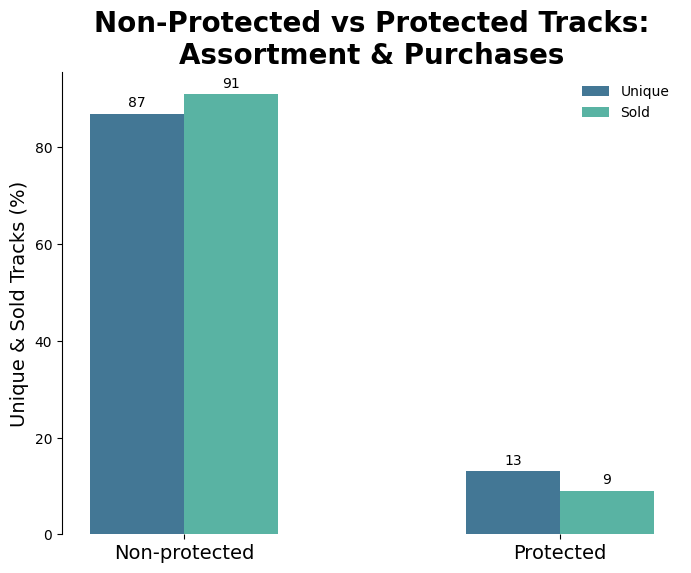

In [19]:
# PLot grouped bar chart with labels

# Define figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Extract labels (non-protected and protected)
labels = df4['media_type'].values
# label locations
x = df4['media_type'].index
# width of the bars
width = 0.25

# Plot non-protected media types
col1 = ax.bar(x - width/2, df4['pct_unique'], width, label='Unique',color='#437795')
# Plot protected media types
col2 = ax.bar(x + width/2, df4['pct_sold'], width, label='Sold',color='#59b3a3')

# Add title, legend, y-axis label and custom x-axis tick labels
ax.set_title('Non-Protected vs Protected Tracks:\nAssortment & Purchases', fontsize=20, fontweight='bold')
ax.set_xticks(x, labels, fontsize=14)
ax.set_ylabel('Unique & Sold Tracks (%)', fontsize=14)
ax.legend(frameon=False)

# Add bar values
ax.bar_label(col1, padding=3)
ax.bar_label(col2, padding=3)

# Remove spines
for location in ['top', 'bottom', 'right']:
    ax.spines[location].set_visible(False)
    ax.spines[location].set_visible(False)
    ax.spines[location].set_visible(False)

plt.show()

In [20]:
# Create new dataframe for pie charts (extract all rows on 'media_type' and 'pct_sold_unique')
df5 = df4.loc[:, ['media_type', 'pct_sold_unique']].copy()

# Create new columns for unsold unique track percentage
df5['pct_unsold_unique'] = 100 - df5['pct_sold_unique']

# Set index as 'media_type'
df5.set_index('media_type', inplace=True)

# Transpose dataframe
df5 = df5.transpose()
df5

media_type,Non-protected,Protected
pct_sold_unique,54.0,34.0
pct_unsold_unique,46.0,66.0


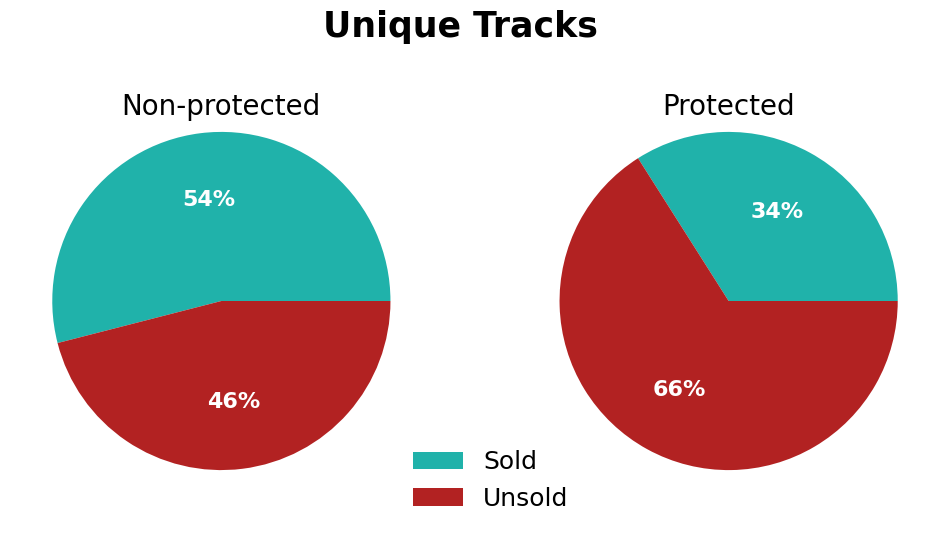

In [21]:
# Plot pie charts of sold and unsold tracks for 'non-proctected' and 'protected' media types
# Define figure and axes
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Unique Tracks', fontsize=25, fontweight='bold', y=0.98)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# Create labels
labels = ['Sold', 'Unsold']
# Add colors
colors = ['lightseagreen', 'firebrick']

# Plot non-protected sold and unsold tracks
ax1.pie(x=df5['Non-protected'], autopct='%.0f%%',
        colors=colors, textprops={'fontsize': 16,
                                  'fontweight': 'bold',
                                  'color': 'white'})
# Add title
ax1.set_title('Non-protected', fontsize=20, y=0.92)

# Plot protected sold and unsold tracks
ax2.pie(x=df5['Protected'], autopct='%.0f%%',
        colors=colors, textprops={'fontsize': 16,
                                  'fontweight': 'bold',
                                  'color': 'white'})
# Add title
ax2.set_title('Protected', fontsize=20, y=0.92)

# Equal aspect to draw the both pie charts
ax.axis('equal')
# Remove x and y axes tick labels
ax.set_xticklabels('')
ax.set_yticklabels('')
# Remove ticks on both axis
ax.tick_params(axis='both', left=False, bottom=False)
# Remove spines from the figure
for key, spine in ax.spines.items():
    spine.set_visible(False)

# Add legend
ax1.legend(fontsize=18, 
           labels=labels,            
           bbox_to_anchor=(0.9,0.2), 
           frameon=False)

plt.show()

From the table above, we can make the following observations:

- Only 13% of all the unique tracks available in the Chinook store are of protected media types.
- From all the unique tracks of protected media types, only 34% were sold, while from those of non-protected ones - 54%.
- Among all the tracks that were sold, those of protected media types amounts only to 9%.

In a nutshell, the tracks of protected media types are much less popular than those of non-protected, both in terms of the store assortment and especially, in terms of sales. It can be easily explained by a cumbersome way of their usage, which is not really justified when it comes to buying media products for entertainment. Hence, as a future strategy, it is not recommended to the store to purchase such tracks from record companies.

## Conclusion

In this project, we have analyzed a modified version of the Chinook database for finding the answers to our business questions. Below are the main findings of this work (emphasized are the factors and suggestions for maximizing overall revenue):

- From the 4 albums in consideration, the following 3 ones should be selected for purchasing and advertising in the USA, based on the genre popularity rating in the country: **Red Tone** (Punk), **Slim Jim Bites** (Blues), **Meteor and the Girls** (Pop).
- Of the 3 sales support agents, **Jane Peacock** demonstrates the most effective sales performance, while Margaret Park - the least. However, together all 3 sales agents help the company to attract local and foreign customers.
- Of all teh countries, the **USA** represents the major part of the market, in terms of both the total sales and the number of customers.
- Customers tend to buy **individual tracks** much more often than the whole albums. Hence, it's recommended to the Chinook store to purchase only the most popular tracks from each album from record companies.
- The tracks of the artists present in the most playlists are all of **Classical genre**, which is not popular among customers. Purchasing them can not be considered as a potentially profitable strategy for the Chinook store.
- Almost half of all the unique tracks of the Chinook store were never bought. Possible solutions here may include a new **advertising campaign**, **sales promotion**, additional **training and motivation** of sales support agents.
- The tracks of **protected** media types are much less popular than those of **non-protected**, both in terms of the store assortment and in terms of sales, especially. Hence the store should avoid purchasing such tracks.